# Sentiment Analysis

TODO: INTRO

# Table of Contents
* [Part 1: Preparations and Topic Extraction](#Part-1:-Preparations-and-Topic-Extraction)
	* [1.1: Natural Language Processing](#1.1:-Natural-Language-Processing)
	* [1.2: Topic Extraction](#1.2:-Topic-Extraction)


* [Part 2: Naive Bayes Approach](#Part-2:-Naive-Bayes-Approach)
	* [2.1: First Approach: Training a Naive Bayes Classifier](#2.1:-First-Approach:-Training-a-Naive-Bayes-Classifier)
	* [2.2: Our Response Array](#2.2:-Our-Response-Array)
	* [2.3: Vectorization and Classification](#2.3:-Vectorization-and-Classification)
	* [2.4: ROC curve](#2.4:-ROC-curve)
	* [2.5: Most discriminative features](#2.5:-Most-discriminative-features)


* [Part 3: Combining topic and sentiment analysis](#Part-3:-Combining-topic-and-sentiment-analysis)
	* [3.1: Find topics for each sentence](#3.1:-Find-topics-for-each-sentence)
	* [3.2: Get stats for each sentence-topic pair](#3.2:-Get-stats-for-each-sentence-topic-pair)


* [Part 4: Second Approach: Using the Loughran-McDonald Financial Dictionary](#Part-4:-Second-Approach:-Using-the-Loughran-McDonald-Financial-Dictionary)
	* [4.1: Adjusting the dictionary for our needs](#4.1:-Adjusting-the-dictionary-for-our-needs)
	* [4.2: Classification using new probabilities](#4.2:-Classification-using-new-probabilities)
	* [4.3: Most positive and most negative sentences](#4.3:-Most-positive-and-most-negative sentences)


* [Part 5: "Forward Guidance:" Lengths of Statements and Federal Reserve Policy](#Part-5:-"Forward-Guidance:"-Lengths-of-Statements-and-Federal-Reserve-Policy)
	* [5.1: Initial EDA on lengths of statements and Fed policy](#5.1:-Initial-EDA-on-lengths-of-statements-and-Fed-policy)
	*[5.2: Carrying out the regression of length on policy action taken](#5.2:-Carrying-out-the-regression-of-length-on-policy-action-taken)
	* [5.3: Regression commentary](#5.3:-Regression-commentary)


* [Part 6: Conclusions and Evaluation](#Part-6:-Conclusions-and-Evaluation)


After scraping for our texts and statistics, we are now ready to move on to analysis of the texts.

In [60]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
from pyquery import PyQuery as pq

# Part 1: Preparations and Topic Extraction

TODO: big picture idea of what we're going to do

## 1.1: Natural Language Processing

We begin by parsing the text and pre-processing it to prepare it for Latent Dirichlet Analysis. This step is meant to remove stopwords and identify nouns and adjectives.

In [61]:
from pattern.en import parse
from pattern.en import pprint
from pattern.vector import stem, PORTER, LEMMA
punctuation = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')

In [3]:
from sklearn.feature_extraction import text 
stopwords=text.ENGLISH_STOP_WORDS

The FOMC statements are full of phrases like "growth is expected to continue--given the current data--at a moderate pace". The two hyphens should be treated as a space.

In [4]:
import re
regex1=re.compile(r"\-{2,}")

We now define a function to find the nouns and adjectives of the text. The function returns a tuple where the first element is a list of lists, where each list includes the nouns from a sentence. The second element is a list of lists, where each list includes the adjectives from a sentence.

In [5]:
def modified_get_parts(thetext):
    thetext=re.sub(regex1, ', ', thetext)
    nouns=[]
    descriptives=[]
    for i,sentence in enumerate(parse(thetext, tokenize=True, lemmata=True).split()):
        
        # Skip the first three sentences that include the HTML
        nouns.append([])
        descriptives.append([])
            
        for token in sentence:
            if len(token[4]) >0:
                if token[1] in ['JJ', 'JJR', 'JJS']:
                    if (token[4] in stopwords or 
                        token[4][0] in punctuation or 
                        token[4][-1] in punctuation or 
                        len(token[4])==1):
                        continue
            
                    descriptives[i].append(token[4])
                elif token[1] in ['NN', 'NNS']:
                    if (token[4] in stopwords or 
                    token[4][0] in punctuation or 
                    token[4][-1] in punctuation or 
                    len(token[4])==1):
                        continue
                    nouns[i].append(token[4])
    out=zip(nouns, descriptives)
    nouns2=[]
    descriptives2=[]
    for n,d in out:
        if len(n)!=0 and len(d)!=0:
            nouns2.append(n)
            descriptives2.append(d)
    return nouns2[1:], descriptives2[1:]

We load in the fomc_mins_all dictionary that we created in the Scraping.ipynb iPython Notebook.

In [6]:
with open("../data/fomc_mins_all.json", "rb") as infile:
    fomc_mins = json.load(infile)

We can now check how our modified_get_parts function would deal with a sample FOMC statement, printing out the first two noun lists.

In [7]:
modified_get_parts(pq(fomc_mins['20140730']).text())[0][:2]

[[u'buildmenu',
  u'policy',
  u'minute',
  u'meeting',
  u'office',
  u'governor',
  u'present',
  u'member',
  u'president',
  u'economist',
  u'dev'],
 [u'governor',
  u'governor',
  u'adviser',
  u'governor',
  u'governor',
  u'governor',
  u'merten',
  u'interval',
  u'meeting',
  u'subcommittee',
  u'communication',
  u'issue']]

We run modified_get_parts on each fomc statement and create a new dictionary fomc_parts. We strip each statement of the html at its start before passing it to modified_get_parts.

In [35]:
%%time
fomc_parts = {}
for key in fomc_mins.keys():
    fomc_parts[key] = modified_get_parts(pq(fomc_mins[key]).text())

Wall time: 1min 14s


In [10]:
fomc_parts_file = open("../data/fomc_parts.json", "wb")
json.dump(fomc_parts, fomc_parts_file)
fomc_parts_file.close()

We can now create two lists, a list of nouns for each sentence, and a flattened list of all the nouns which we will create to produce a dictionary (needed as an argument for the LDA function).

In [11]:
nvocab = []
for key in fomc_mins.keys():
    nouns = fomc_parts[key][0]
    for nounlist in nouns:
        nvocab.append(nounlist)

flattenednvocab = []
for key in fomc_mins.keys():
    nouns = fomc_parts[key][0]
    for nounlist in nouns:
        for n in nounlist:
            flattenednvocab.append(n)

In [41]:
from collections import Counter
frequency = Counter(flattenednvocab)

In [13]:
id2word = {}; vocab = {}
for i,word in enumerate(frequency.keys()):
    vocab[word] = i 
    id2word[i] = word

In [14]:
len(vocab.keys())

2759

In [15]:
from collections import defaultdict
def sentencelist(sentence):
    d = defaultdict(int); group = []
    for word in sentence:
        word_id = vocab[word] 
        d[word_id] += 1 
    group = [(a, d[a]) for a in d.keys()]
    return group
corpus = [sentencelist(sentence) for sentence in nvocab]

## 1.2: Topic Extraction

We first begin by extracting topics from our corpus. This may prove to be useful later when we run a naive Bayes classifier.

In [16]:
import gensim

In [20]:
# We found that using 3 topics was ideal for topic differentiation
lda2 = gensim.models.ldamodel.LdaModel(corpus, num_topics=3, id2word = id2word, update_every=1, chunksize=300)

In [21]:
lda2.print_topics()

[(0,
  u'0.077*policy + 0.036*member + 0.032*business + 0.026*meeting + 0.021*sale + 0.020*outlook + 0.020*discussion + 0.017*investment + 0.015*information + 0.014*statement'),
 (1,
  u'0.068*market + 0.061*rate + 0.040*participant + 0.029*condition + 0.028*fund + 0.025*period + 0.021*percent + 0.019*range + 0.019*security + 0.015*objective'),
 (2,
  u'0.061*inflation + 0.049*price + 0.037*growth + 0.026*quarter + 0.025*year + 0.023*increase + 0.023*pace + 0.022*consumer + 0.020*month + 0.019*labor')]

We print out a number of bags of words in order to better identify the three topics we identified.

In [22]:
for bow in corpus[0:900:15]:
    print bow
    print lda2.get_document_topics(bow)
    print " ".join([id2word[e[0]] for e in bow])
    print "=========================================="

[(2552, 1)]
[(0, 0.66114129645326436), (1, 0.16666775219058128), (2, 0.17219095135615431)]
member
[(640, 1), (1600, 1), (2356, 1), (2463, 1)]
[(0, 0.66764801384407035), (1, 0.26567445244797694), (2, 0.066677533707952721)]
dealer issue bid ability
[(135, 1), (1493, 1), (2575, 1)]
[(0, 0.46489675612167169), (1, 0.45176770623426538), (2, 0.083335537644062957)]
currency paragraph transaction
[(1040, 1), (834, 1), (164, 1), (141, 1), (2134, 1)]
[(0, 0.26179487531122031), (1, 0.68071667913613776), (2, 0.057488445552641876)]
sale spot purchase end exchange
[(2584, 1), (524, 1), (13, 1), (1590, 1)]
[(0, 0.066681016155706846), (1, 0.86664528914737304), (2, 0.066673694696920111)]
drawing character swap operation
[(675, 2), (389, 1), (106, 1), (1771, 1), (1712, 1), (20, 1), (1399, 1), (2552, 1), (69, 1)]
[(0, 0.7679572572387322), (1, 0.20026796284879375), (2, 0.031774779912474078)]
time approach assessment announcement wording risk condition member balance
[(892, 1), (905, 1), (779, 1), (844, 1),

We find there to be three main topics that can be extracted from the corpus. The first topic is related to actions of the Federal Reserve and its assessment of the economy. The inclusion of words like "development", "growth", "policy", "meeting", etc. all speak to the objectives of the Fed and its focus on economic growth.

Topic two relates to deals, and economic transactions. Relevant words include "security", "repurchase", "transaction", "purchase", "sale", and "exchange". These are all words relating to transactions and economic activity.

Finally, topic three relates to broader macroeconomic trends and positive public perception of the economy. Here, relevant words include "income", "confidence", "outlook", "consumer spending", "strength", and "appreciation". This topic seems to imply a perception of growth or economic development

# Part 2: Naive Bayes Approach

Now that we have identified a number of topics within our corpus, we can calculate individual probibilities for words falling into our topics. We identify the probability for each word in two ways: first, we construct a vectorizer to identify features; second, we identify probabilities using the McDonald financial dictionary.

## 2.1: First Approach: Training a Naive Bayes Classifier

We create the vocabulary of adjectives that we will use.

In [43]:
flattened_adj_vocab = []
for key in fomc_mins.keys():
    nouns = fomc_parts[key][1]
    for nounlist in nouns:
        for n in nounlist:
            flattened_adj_vocab.append(n)

frequency2 = Counter(flattened_adj_vocab)
id2adj = {}; adjvocab = {}
for i,word in enumerate(frequency2.keys()):
    adjvocab[word] = i 
    id2adj[i] = word

We combine the adjectives in each statement into a single list and thereby have a list of adjectives for each review.

In [24]:
X = []
for key in fomc_mins.keys():
    nouns = fomc_parts[key][1]
    for nounlist in nouns:
        X.append(nounlist)

The most common words are listed below:

In [25]:
dict_words = Counter(flattened_adj_vocab)
list_words = []
for key in dict_words:
    list_words.append((dict_words[key], key))
sorted(list_words, reverse=True)

[(5388, u'economic'),
 (3074, u'recent'),
 (2874, u'financial'),
 (2771, u'foreign'),
 (2236, u'monetary'),
 (1901, u'federal'),
 (1768, u'intermeeting'),
 (1751, u'likely'),
 (1550, u'real'),
 (1321, u'low'),
 (1298, u'domestic'),
 (1222, u'consistent'),
 (1168, u'moderate'),
 (1100, u'higher'),
 (1068, u'little'),
 (1043, u'current'),
 (1014, u'fourth'),
 (975, u'second'),
 (938, u'new'),
 (887, u'strong'),
 (880, u'high'),
 (863, u'appropriate'),
 (856, u'overall'),
 (813, u'large'),
 (774, u'available'),
 (733, u'longer-term'),
 (724, u'open'),
 (688, u'substantial'),
 (669, u'fiscal'),
 (658, u'nominal'),
 (630, u'average'),
 (628, u'unchanged'),
 (626, u'previous'),
 (616, u'major'),
 (606, u'industrial'),
 (600, u'sustainable'),
 (584, u'robust'),
 (579, u'total'),
 (557, u'potential'),
 (554, u'retail'),
 (541, u'significant'),
 (534, u'additional'),
 (515, u'unanimous'),
 (513, u'longer-run'),
 (508, u'sizable'),
 (499, u'commercial'),
 (497, u'past'),
 (496, u'lower'),
 (495,

The most commonly used words in FOMC statements closely aligns with our expectations of the language commonly used by the Federal Reserve. There is a heavy focus on economic terms.

## 2.2: Our Response Array

We load a JSON file containing changes in the federal funds rate and an indicator of whether the rate has increased or decreased since the previous change.

In [14]:
with open("../data/actions_05-15.json", "rb") as infile:
    decisions = json.load(infile)
len(decisions.keys())

52

We now check to see how many of the keys in our corpus also appear in the list of changes to the federal funds rate.

In [27]:
decisions_work = decisions.copy()
new_decisions = {}
for key in fomc_mins:
    if key in decisions_work.keys():
        new_decisions[key] = decisions_work[key][-1]
        del decisions_work[key]
        
len(new_decisions)

47

We now have a group of statements and decisions, where the statements are releases made at certain dates and decisions are interest rate decisions made at certain dates. We process the data to ensure the two datasets have the same dimensions and fill in missing data with 0s (*i.e.* no change since the last statement).

In [15]:
for key in fomc_mins.keys():
    if key < min(decisions.keys()):
        del fomc_mins[key]

In [16]:
len(fomc_mins)
for key in fomc_mins.keys():
    if key not in decisions.keys():
        decisions[key] = [0,0,0,0,0]
len(fomc_mins.keys())

103

In [17]:
len(decisions)

108

In [36]:
X = []; y = []
for key in fomc_mins.keys():
    l = ""
    adjs = fomc_parts[key][1]
    for adjlist in adjs:
        for a in adjlist:
#             if dict_words[a] > 1000:
            l = l + " " + a
    X.append(l)
    y.append(decisions[key][2])
newy=[]
for a in y:
    if a == 0 or a == -1:
        newy.append(0)
    else:
        newy.append(1)
X = np.array(X)
y = np.array(newy)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0])

## 2.3: Vectorization and Classification

We split our data into a training and testing set to run our vectorizer. Below code is adapted from previous CS109 course materials.

In [50]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(len(X)), train_size=0.7)
mask=np.ones(len(X), dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [46]:
def make_xy(X_col, y_col, vectorizer):
    X = vectorizer.fit_transform(X_col)
    y = y_col
    return X, y

In [47]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to 
a Naive Bayes classifier. 
The Log Likelihood is defined by

L = Sum_positive(logP(positive)) + Sum_negative(logP(negative))

Where Sum_positive indicates a sum over all positive reviews, 
and Sum_negative indicates a sum over negative reviews
    
Parameters
----------
clf : Naive Bayes classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten,0].sum() + prob[fresh,1].sum()

In [48]:
from sklearn.cross_validation import KFold

def cv_score(clf, x, y, score_func, nfold=5):
    """
    Uses 5-fold cross validation to estimate a score of a classifier
    
    Inputs
    ------
    clf : Classifier object
    x : Input feature vector
    y : Input class labels
    score_func : Function like log_likelihood, that takes (clf, x, y) as input,
                 and returns a score
                 
    Returns
    -------
    The average score obtained by splitting (x, y) into 5 folds of training and 
    test sets, fitting on the training set, and evaluating score_func on the test set
    
    Examples
    cv_score(clf, x, y, log_likelihood)
    """
    result = 0
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf, x[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

In [51]:
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
maxi = -np.inf; best_alpha = 0; best_min_df = 0
for m in min_dfs:
    for a in alphas:
        vectorizer = CountVectorizer(vocabulary=adjvocab, min_df = m) 
        x_new, y_new = make_xy(X,y,vectorizer)
        Xtrainthis=x_new[mask]
        ytrainthis=y_new[mask]
        clf = MultinomialNB(alpha=a)
        score = cv_score(clf, Xtrainthis, np.ravel(ytrainthis), log_likelihood)
        if (score > maxi):
            maxi = score
            best_alpha = a
            best_min_df = m

In [39]:
print "alpha: %f" % best_alpha
print "min_df: %f" % best_min_df

alpha: 0.100000
min_df: 0.000010


In [40]:
vectorizer = CountVectorizer(vocabulary=adjvocab, min_df=best_min_df)
Xnew, ynew = make_xy(X, y, vectorizer)
xtrain=Xnew[mask]
ytrain=ynew[mask]
xtest=Xnew[~mask]
ytest=ynew[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Accuracy on training data: %0.4f" % (training_accuracy)
print "Accuracy on test data:     %0.4f" % (test_accuracy)



Accuracy on training data: 0.9444
Accuracy on test data:     0.9355


**We then compare this to the baseline where we predict all values as 0:**

In [52]:
base_count1 = sum([1 for e in y if e == 0])
base_pct1 = base_count1/float(len(decisions))
print "Baseline percentage is", base_count1, "/", len(decisions), "=", base_pct1

Baseline percentage is 86 / 108 = 0.796296296296


**The accuracy of the naive Bayes classifier is substantially higher than the baseline.**

## 2.4: ROC curve

In [31]:
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

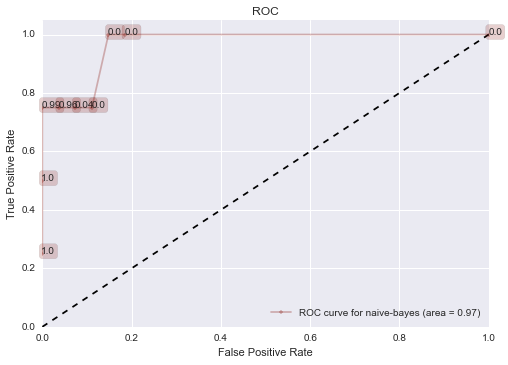

In [54]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("naive-bayes",clf, ytest, xtest, labe=1, skip=1)

As standard practice, we also wanted to construct an ROC curve for evaluating our model. Although the resulting plot technically is a "good" ROC curve, it is more significant in the fact that it indicates that our analysis would benefit from more data points. We can see that most of the points are clustered around quanta within the lower FPR (false positive rate) region.

## 2.5: Most discriminative features

What are the most discriminative features according to our classifier? The visualization belows shows the top 20 features in terms of the differences between their positive and negative log probabilities for classification.

In [55]:
# We found the absolute difference between log positive and
# log negative and output the top 20

features_list = vectorizer.get_feature_names()
feature_probs = clf.feature_log_prob_
lognegatives = {}; logpositives = {}; i = 0
positives = []
negatives = []
difference = []

for a in features_list:
    lognegatives[a] = feature_probs[0][i]
    logpositives[a] = feature_probs[1][i]
    positives.append((feature_probs[0][i],a))
    negatives.append((feature_probs[1][i],a))
    difference.append((abs(feature_probs[0][i] - feature_probs[1][i]),a))
    i += 1

sorted_p = sorted(difference, reverse=True)
print sorted_p[:20]


[(4.0556363117322425, u'backed'), (3.8573847284265472, u'mortgage'), (3.7956356853776416, u'upgrade'), (3.3538029330986028, u'accompanying'), (3.236019897442219, u'technological'), (3.236019897442219, u'flush'), (3.236019897442219, u'attendant'), (2.9483378249904382, u'wary'), (2.9483378249904382, u'refined'), (2.9483378249904382, u'obsolete'), (2.9483378249904382, u'extensive'), (2.9483378249904373, u'buoyant'), (2.9483378249904373, u'benign'), (2.9293979567892015, u'principal'), (2.8416223459068153, u'broader'), (2.8231032981395776, u'sovereign'), (2.7660162681964833, u'indirect'), (2.7660162681964833, u'accelerated'), (2.7453943138122616, u'gross'), (2.5569937109419252, u'primary')]


We display the most discriminative words on the plot below.

(-1, 20)

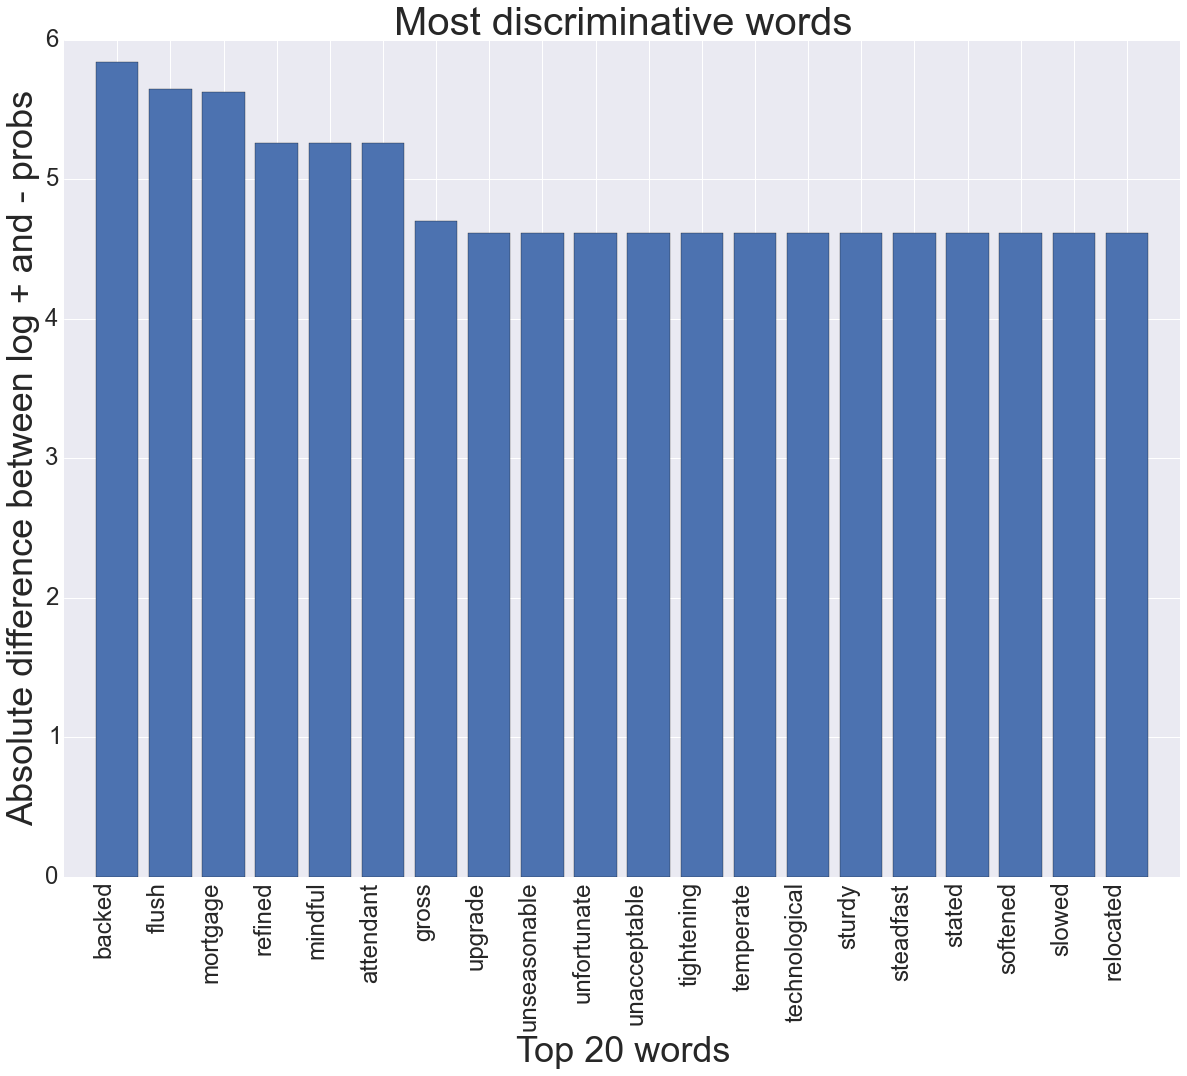

In [118]:
FTSZ = 24;

y_pdwords = [a[0] for a in sorted_p[:20]]
x_pdwords = [a[1] for a in sorted_p[:20]]
numbers = np.arange(len(x_pdwords))
width = 0.3
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.bar(numbers,y_pdwords, align='center')
ax.set_xticks(numbers)
ax.set_xticklabels(x_pdwords, rotation='vertical', ha='right');
ax.set_xlabel("Top 20 words", fontsize=FTSZ+12)
ax.tick_params(labelsize=FTSZ)
ax.set_ylabel("Absolute difference between log + and - probs ", fontsize=FTSZ+12)
ax.set_title("Most discriminative words", fontsize=FTSZ+16);
ax.set_xlim(-1,len(numbers))

(We ran this multiple times so the words above may change on each interation so the terms that we mention may not necessarily be present in the iteration above.) It is interesting to note that words like "mortgage," "relocation," "upgrade," "technological," *etc.*, which are typically associated with change and reform (in this case, likely to be about reevaluation of FOMC monetary/fiscal policies), are among the words that are most likely to be clearly defined to a particular topic class. In some sense, these words are the most "divisive" within the FOMC statements. 

# Part 3: Combining topic and sentiment analysis

TODO: insert descriptions for procedure here

## 3.1: Find topics for each sentence

### Calculate Adjectives' Log Probabilities

In [215]:
logpositives = dict(zip(vectorizer.get_feature_names(),clf.feature_log_prob_[1]))
lognegatives = dict(zip(vectorizer.get_feature_names(),clf.feature_log_prob_[0]))

In [216]:
vectorizer.vocabulary_

{u'limited': 0,
 u'28-day': 1,
 u'four-year': 2,
 u'desirable': 3,
 u'asian': 4,
 u'controversial': 5,
 u'home-price': 6,
 u'lower-rated': 7,
 u'eligible': 8,
 u'contained': 9,
 u'employment-to-population': 10,
 u'undergird': 11,
 u'slowest': 12,
 u'worth': 13,
 u'divergent': 14,
 u'difficult-to-fill': 15,
 u'dynamic': 16,
 u'regional': 17,
 u'softened': 18,
 u'anemic': 19,
 u'managerial': 20,
 u'contemplated': 351,
 u'new-issue': 22,
 u'correct': 717,
 u'unrelated': 24,
 u'market\x92s': 25,
 u'tax-induced': 26,
 u'march-april': 27,
 u'straight': 28,
 u'triple-b-rated': 29,
 u'pragmatic': 30,
 u'concise': 31,
 u'consistent': 32,
 u'intermeeeting': 33,
 u'direct': 34,
 u'\xa0\xa0mortgage-backed': 35,
 u'disciplined': 36,
 u'likely': 37,
 u'wealth-to-income': 38,
 u'estimated': 39,
 u'take-up': 40,
 u'established': 41,
 u'deliberate': 42,
 u'selected': 43,
 u'consequent': 44,
 u'unskilled': 45,
 u'\xa0in': 46,
 u'hefty': 720,
 u'resilient': 48,
 u'new': 49,
 u'net': 50,
 u'upward': 1857,

In [217]:
def calc_pplus1(adjlist, lp, ln, pp, pn):
    
    # sum log probabilities
    apos = 0
    aneg = 0
    for adj in adjlist:
        apos += lp[adj]
        aneg += ln[adj]
    
    # take exponent to find probability
    apos = np.exp(apos)
    aneg = np.exp(aneg)
    
    # calculate fraction
    numer = apos*pp
    denom = numer + aneg*pn
    
    return numer/denom

In [235]:
def choose_topic(ldamodel, bow):
    tee = lda2.get_document_topics(bow)
    if len(tee)==3:
        t1,t2,t3=tee
        k=[t1,t2,t3]
        check1 = [t1[1],t2[1],t3[1]]
        maxi_prob = k[check1.index(max(check1))]#get higher probability topic
        topicis = maxi_prob[0]
    else:
        topicis=tee[0][0]
    return topicis

In [236]:
priorp = np.mean(y)
priorn = 1 - priorp

print "Prior P(+): ", priorp
print "Prior P(-): ", priorn

Prior P(+):  0.165048543689
Prior P(-):  0.834951456311


In [237]:
%%time

counter=0
minutesdict={}
for i, mindate in enumerate(fomc_mins):
    rlist=[]
    nlist, alist = fomc_parts[mindate]
    ln=len(nlist)
    localbow=corpus[counter:counter+ln]
    for bow, adj, noun in zip(localbow, alist, nlist):
        doc=" ".join([id2word[e[0]] for e in bow])
        pplus=calc_pplus1(adj, logpositives, lognegatives, priorp, priorn)
        topicis=choose_topic(lda2, bow)
        ldict={"topic": topicis, 'pplus':pplus}
        rlist.append(ldict)
    minutesdict[mindate]=rlist
    counter=counter+ln


Wall time: 5.33 s


In [238]:
minutesdict

{u'20021210': [{'pplus': 0.21556092141826078, 'topic': 2},
  {'pplus': 0.20060886056494456, 'topic': 1},
  {'pplus': 0.25361572454672376, 'topic': 2},
  {'pplus': 0.2329803273213201, 'topic': 1},
  {'pplus': 0.30392290177966913, 'topic': 1},
  {'pplus': 0.10566720075745249, 'topic': 2},
  {'pplus': 0.25361572454672376, 'topic': 1},
  {'pplus': 0.033686066222183279, 'topic': 1},
  {'pplus': 0.14215231334409559, 'topic': 2},
  {'pplus': 0.39932024456498821, 'topic': 1},
  {'pplus': 0.050000963526457672, 'topic': 1},
  {'pplus': 0.21740841489279844, 'topic': 1},
  {'pplus': 0.091891039837216484, 'topic': 1},
  {'pplus': 0.41084878023525229, 'topic': 1},
  {'pplus': 0.21208401863770132, 'topic': 0},
  {'pplus': 0.18049451389226337, 'topic': 0},
  {'pplus': 0.1440841981011064, 'topic': 0},
  {'pplus': 0.22468621133656194, 'topic': 0},
  {'pplus': 0.042300520654671894, 'topic': 1},
  {'pplus': 0.48892892131131405, 'topic': 1},
  {'pplus': 0.068268852481590495, 'topic': 1},
  {'pplus': 0.1588

In [240]:
pd.DataFrame(minutesdict['20021210']).head()

,pplus,topic
0,0.215561,2
1,0.200609,1
2,0.253616,2
3,0.232980,1
4,0.303923,1


In [241]:
minsentdf = pd.DataFrame({'date': 'exdate', 'pplus': 0, 'topic': 7}, index=['date'])

for k in minutesdict.keys():
    for s in minutesdict[k]:
        s['date'] = k
    newdf = pd.DataFrame(minutesdict[k])
    minsentdf = pd.concat([minsentdf, newdf])
    
minsentdf.reset_index
minsentdf.set_index('date')
minsentdf = minsentdf.ix[1:]

In [242]:
minsentdf.head(5)

,date,pplus,topic
0,20040128,0.215561,0
1,20040128,0.200609,0
2,20040128,0.215561,0
3,20040128,0.259606,0
4,20040128,0.215561,2


## 3.2: Get stats for each sentence-topic pair

In [243]:
def get_stats(group):
    minval = np.min(group.pplus)
    maxval = np.max(group.pplus)
    count = group.date.count()
    mean = np.mean(group.pplus)
    
    # special case for variance
    var = 0
    if np.var(group.pplus, ddof=1):
        var = np.var(group.pplus)
    
    # create dataframe
    outdf = pd.DataFrame({'min': [minval], 'max': [maxval],
                          'count': [count], 'var': [var], 'mean': [mean]})
    outdf.set_index('mean')
    
    return outdf

In [268]:
dftouse=minsentdf.groupby(['date', 'topic']).apply(get_stats).reset_index()
dftouse = dftouse[['date','topic','count','max','mean','min','var']]

In [276]:
dftouse.head()

,date,topic,count,max,mean,min,var
0,20021210,0,25,0.948605,0.213491,0.000582,0.050994
1,20021210,1,29,0.991405,0.222818,0.000790,0.046069
2,20021210,2,53,0.917057,0.285482,0.001613,0.064409
3,20030129,0,37,0.798947,0.230695,0.000435,0.038318
4,20030129,1,83,0.943150,0.260238,0.008593,0.051788


In [277]:
c0df=dftouse[dftouse.topic==0]
c1df=dftouse[dftouse.topic==1]
c2df=dftouse[dftouse.topic==2]

In [278]:
from scipy.special import erf
prob= lambda mu, vari, num: .5 * (1 - erf((0.5- mu) / np.sqrt(2 * vari/float(num))))

In [279]:
c0df['ppos'] = c0df.apply(lambda row: prob(row['mean'], row['var'], row['count']), axis=1)
c1df['ppos'] = c1df.apply(lambda row: prob(row['mean'], row['var'], row['count']), axis=1)
c2df['ppos'] = c2df.apply(lambda row: prob(row['mean'], row['var'], row['count']), axis=1)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

In [280]:
c0df.head()

,date,topic,count,max,mean,min,var,ppos
0,20021210,0,25,0.948605,0.213491,0.000582,0.050994,1.120829e-10
3,20030129,0,37,0.798947,0.230695,0.000435,0.038318,5.551115e-17
6,20030318,0,26,0.644245,0.205591,0.005734,0.036271,1.609823e-15
9,20030506,0,39,0.990896,0.208797,0.000341,0.063760,2.966516e-13
12,20030625,0,27,0.928269,0.253831,0.000530,0.064105,2.185452e-07


In [281]:
c1df.head()

,date,topic,count,max,mean,min,var,ppos
1,20021210,1,29,0.991405,0.222818,0.000790,0.046069,1.770584e-12
4,20030129,1,83,0.943150,0.260238,0.008593,0.051788,0.000000e+00
7,20030318,1,39,0.929089,0.228218,0.026984,0.046764,2.109424e-15
10,20030506,1,30,0.745630,0.228524,0.000107,0.049117,9.778844e-12
13,20030625,1,82,0.872148,0.209246,0.001747,0.046297,0.000000e+00


In [282]:
c2df.head()

,date,topic,count,max,mean,min,var,ppos
2,20021210,2,53,0.917057,0.285482,0.001613,0.064409,3.787498e-10
5,20030129,2,60,0.930081,0.221219,0.000295,0.040934,0.000000e+00
8,20030318,2,53,0.913324,0.230161,0.000234,0.050214,0.000000e+00
11,20030506,2,63,0.972260,0.240799,0.000396,0.045673,0.000000e+00
14,20030625,2,42,0.897491,0.176106,0.000825,0.035417,0.000000e+00


In [283]:
ppos0 = np.sum(c0df.ppos.values > 0.5) / np.float(c0df.shape[0])
ppos1 = np.sum(c1df.ppos.values > 0.5) / np.float(c1df.shape[0])
ppos2 = np.sum(c2df.ppos.values > 0.5) / np.float(c2df.shape[0])

print "Fraction positive in topic 0: ", ppos0
print "Fraction positive in topic 1: ", ppos1
print "Fraction positive in topic 2: ", ppos2

Fraction positive in topic 0:  0.0194174757282
Fraction positive in topic 1:  0.00970873786408
Fraction positive in topic 2:  0.0


TODO: Add comment here about the above. Keep in mind that the original priorp was 0.16 and priorn was 0.84.

TODO: maybe add some more descriptions of the code from the homework.

# Part 4: Second Approach: Using the Loughran-McDonald Financial Dictionary

## 4.1: Adjusting the dictionary for our needs

Our first approach assigned probabilities to words based on the training set of FOMC statements we have. However, the success of this is limited by the number of FOMC statements (182) that we have access to. We can improve this analysis by using more accurate probabilities given by a dictionary that focuses on finance. The **Loughran-McDonald 2014 Master Dictionary** is a great tool for our purposes as it includes words that often appear in 10-K documents and other financial statements. The dictionary includes 9 sentiment categories, including "negative", "positive", "uncertainty", "litigious", "modal", and "constraining", among others. The categories given by this dictionary are more useful to us because of the sheer size of the data set used.

We read in the data. Below is an example of the data encapsulated in $lmdf$.

In [96]:
lmdf = pd.read_csv("../data/shortMcDonaldDictionary.csv")
lmdf.head()

,Word,Sequence Number,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Constraining,Superfluous,Interesting,Modal,Irr_Verb,Harvard_IV,Syllables,Source
0,ENCUMBER,24454,87222,6.130000e-06,2.570000e-06,0.000017,44863,2009,0,0,2009,2009,0,0,0,0,0,3,12of12inf
1,ENCUMBERED,24455,86996,6.110000e-06,3.480000e-06,0.000028,44409,2009,0,0,2009,2009,0,0,0,0,0,3,12of12inf
2,ENCUMBERING,24456,51445,3.610000e-06,3.660000e-06,0.000050,19907,2009,0,0,2009,2009,0,0,0,0,0,4,12of12inf
3,ENCUMBERS,24457,4835,3.400000e-07,1.380000e-07,0.000004,3258,2009,0,0,2009,2009,0,0,0,0,0,3,12of12inf
4,ENCUMBRANCE,24458,223181,1.570000e-05,6.260000e-06,0.000036,72129,2009,0,0,2009,2009,0,0,0,0,0,3,12of12inf


In [97]:
lmdf = lmdf[["Word","Negative","Positive","Uncertainty","Litigious","Constraining"]]

In [98]:
lmdf.head()

,Word,Negative,Positive,Uncertainty,Litigious,Constraining
0,ENCUMBER,2009,0,0,2009,2009
1,ENCUMBERED,2009,0,0,2009,2009
2,ENCUMBERING,2009,0,0,2009,2009
3,ENCUMBERS,2009,0,0,2009,2009
4,ENCUMBRANCE,2009,0,0,2009,2009


The dictionary includes 9 sentiment categories (e.g. "negative", "positive", "uncertainty", "litigious", "modal", and "constraining"). We reduce the dimensionality of this data down to just three categories: "negative", "positive", and "uncertain". A $word$ that is "uncertain" is assigned the probabilities $$P(word_u\,|\,-)=P(word_u\,|\,+)=\frac{1}{2}$$
We set words in the "positive" and "negative" parts to have 90% probabilities of being in the group they are assigned to (based on the average probability given by Loughran and McDonald).
$$P(word_p\,|\,+) = 0.9, P(word_p\,|\,-) = 0.1$$
$$P(word_n\,|\,-) = 0.1, P(word_n\,|\,-) = 0.9$$

We adjust $lmdf$ to reflect these decisions.

In [99]:
lmdf_adjusted = lmdf.copy(deep=True)
N = 0; P = 0
new_values = [0 for i in range(len(lmdf_adjusted.values))]
for i, r in enumerate(lmdf_adjusted.values):
    if r[1] > 0 or r[4] > 0 or r[5] > 0:
        N = 0.9; P = 0.1
    elif r[2] > 0:
        N = 0.1; P = 0.9
    elif r[3] > 0:
        N = 0.5; P = 0.5
    new_values[i] = [r[0].lower(), P, N]

final_lmdf = pd.DataFrame(new_values, index=lmdf_adjusted.index, columns = ["Word", "Positive Prob", "Negative Prob"])
final_lmdf.head()

,Word,Positive Prob,Negative Prob
0,encumber,0.1,0.9
1,encumbered,0.1,0.9
2,encumbering,0.1,0.9
3,encumbers,0.1,0.9
4,encumbrance,0.1,0.9


We define a function to calculate the probability of a sentence being positive.

In [75]:
dict_probs = {}
for row in final_lmdf.values:
    dict_probs[row[0]] = [row[1], row[2]]

In [70]:
statements = []
for key in fomc_mins.keys():
    adj = fomc_parts[key][1]
    statements.append(adj)

## 4.2: Classification using new probabilities

We define a function that calculates the probability of a statement being positive or negative. The function calculates the probability of each sentence being positive or negative and then sums up the total probabilities. Finally, it normalizes the overall probability.

In [113]:
def modified_calc_pplus(adjlist, dict_probs, lp, ln, pp, pn):
    FACTOR = 1
    
    prob_p = 0; prob_n = 0
    for adj in adjlist:
        # Check if the adjective is in the financial dictionary
        # If it is take, probability from there
        if adj.lower() in dict_probs.keys():
            prob_p += np.log10(FACTOR * dict_probs[adj][0])
            prob_n += np.log10(FACTOR * dict_probs[adj][1])
        else:
            prob_p += lp[adj]
            prob_n += ln[adj]
    prob_pos = (10**prob_p) * pp
    prob_neg = (10**prob_n) * pn
    prob = float(prob_pos)/(prob_pos + prob_neg)
    return prob

In [72]:
def statement_prob_pos(statement, adjlist, dict_probs, lp, ln, pp, pn):
    prob_p = 0; prob_n = 0
    for sent in statement:
        prob_p += np.log10(modified_calc_pplus(sent, dict_probs, lp, ln, pp, pn))
        prob_n += np.log10(1-modified_calc_pplus(sent, dict_probs, lp, ln, pp, pn))
    prob_pos = (10**prob_p) * pp
    prob_neg = (10**prob_n) * pn
    prob = float(prob_pos)/(prob_pos + prob_neg)
    return prob

Below we verify that our probability calculate works with an example sentence.

In [115]:
statement_prob_pos(statements[2], adjlist, dict_probs, logpositives, lognegatives, np.mean(y), 1-np.mean(y))

1.4850498758446296e-94

We now calculate the probability that a statement is positive for all statements.

In [117]:
%%time
X_full = []; y_full = []; our_results = []
for key in fomc_mins.keys():
    adjs = fomc_parts[key][1]
    X_full.append(adjs)
    y_full.append(decisions[key][2])
    prob = statement_prob_pos(adjs, adjlist, dict_probs, logpositives, lognegatives, np.mean(y), 1-np.mean(y))
    if prob <= 0.5:
        prob = 0
    else:
        prob = 1
    our_results.append(prob)

Wall time: 1min 29s


In [126]:
correct = 0
for i in range(len(y_full)):
    if y_full[i] == -1:
        y_full[i] = 0
    if y_full[i] == our_results[i]:
        correct += 1
    score = float(correct)/len(y_full)
print "Our classfier accuracy score:", score

Our classfier accuracy score: 0.980582524272


In [128]:
wrong_fomc_pred1 = []

for i in range(1,len(y_full)):
    if y_full[i] != our_results[i]:
        wrong_fomc_pred1.append(fomc_mins.keys()[i])

print "Incorrect dates:", wrong_fomc_pred1

Incorrect dates: [u'20060808', u'20070628']


In [133]:
print "Number of 1s in reality:", sum(y_full)
print "Number of 1s in model:  ", sum(our_results)

Number of 1s in reality: 17
Number of 1s in model:   19


## 4.3: Most positive and most negative sentences

TODO: Potential commentary: We can find the most "positive" and most "negative" sentences and comment on that.

TODO: check on code below.

In [ ]:
%%time

maxlim = -10
maxs = []
NUMTOLIM = np.inf

topctr = 0

for s in statements:
    ps = statement_prob_pos(s, adjlist, dict_probs, 
                            logpositives, lognegatives, 
                            np.mean(y), 1-np.mean(y))
    
    if ps > maxlim:
        maxlim = ps
        maxs = s
        
        print maxlim
    
    if ps == 0:
        print fomc_mins.keys()[topctr]

# Part 5: "Forward Guidance:" Lengths of Statements and Federal Reserve Policy

## 5.1: Initial EDA on lengths of statements and Fed policy

The Federal Reserve has claimed at several points in the past decade that it attempts to affect financial markets (especially post-crisis) through the release of increasingly long statements that help outline and bring about the changes it hopes for. We take this as a launch pad for another potential statistical analysis that may turn out to be useful for our work. We examine the relationship between the length of statements and their outcomes.

Indeed, the length of statements varies greatly from statement to statement. For example, let us compare two statements from 2014 and 2002.

In [13]:
print len(pq(fomc_mins['20140730']).text()), len(pq(fomc_mins['20021210']).text())

53905 22899


The statement from 2014 is twice as long as that of 2002 (this is line with the Fed's promise of more locquacious public statements).

This is pattern is even more striking when we visualize it as shown below.

### Moving Average

In addition to the actual data, we include moving average time series to better visualize trends in the data.

In [64]:
"""
moving average code courtsey of
http://stackoverflow.com/questions/11352047/finding-moving-average-from-data-points-in-python
"""
def movingaverage(interval, window_size=5):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'valid')

In [65]:
length_time = [(key, len(pq(fomc_mins[key]).text())) 
               for key in fomc_mins.keys()]
    
sorted_length = sorted(length_time)

length_time_df = pd.DataFrame(sorted_length, columns = ["Date", "Length"])
length_time_df.head()

a_win_sz = 10
b_win_sz = 30

lt_mvga_a = movingaverage(length_time_df["Length"], a_win_sz)
lt_mvga_b = movingaverage(length_time_df["Length"], b_win_sz)

Now we plot the data along with the moving averages of various window sizes to see overall rate changes and trends.

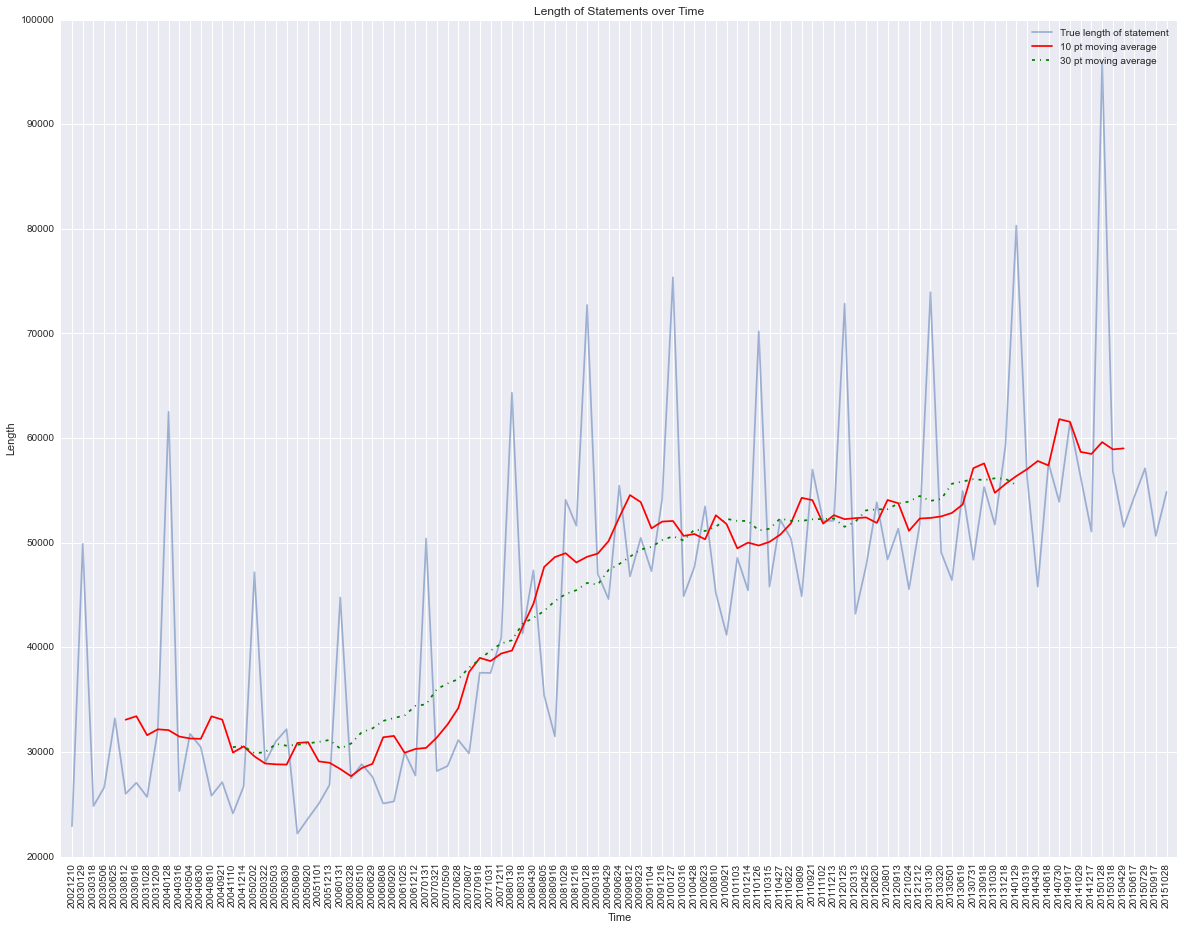

In [67]:
# plot the data

width = 0.3
fig = plt.figure(figsize=(20,15), facecolor='white')

ax = fig.add_subplot(111)

ax.plot(range(len(length_time_df)), length_time_df["Length"],alpha=0.5,label='True length of statement');
ax.plot(range(a_win_sz/2,len(lt_mvga_a)+a_win_sz/2), lt_mvga_a, color="red", linestyle="-",label=str(a_win_sz)+' pt moving average');
ax.plot(range(b_win_sz/2,len(lt_mvga_b)+b_win_sz/2), lt_mvga_b, color="green", linestyle="-.",label=str(b_win_sz)+' pt moving average');

ax.set_xticks(range(len(length_time_df)));
ax.set_xticklabels(length_time_df["Date"], rotation='vertical')
ax.set_xlim(-1,len(length_time_df))

ax.legend();

ax.set_xlabel("Time");
ax.set_ylabel("Length");
ax.set_title("Length of Statements over Time");

## 5.2: Carrying out the regression of length on policy action taken

We now prepare data to carry out a regression.

In [8]:
import statsmodels.api as sm
from statsmodels.formula.api import glm, ols

In [9]:
"""
length_ols_model = ols('Y ~ Length', length_data).fit()
length_ols_model.summary()
"""

"\nlength_ols_model = ols('Y ~ Length', length_data).fit()\nlength_ols_model.summary()\n"

In [30]:
for key in decisions.keys():
    if decisions[key][2] == -1:
        decisions[key][2] = 0
        
length = []
for key in fomc_mins.keys():
    new = (len(pq(fomc_mins[key]).text()),decisions[key][2])
    length.append(new)
    
length_data = pd.DataFrame(length, columns = ["Length", "Y"])
length_data.head()

,Length,Y
0,62507,0
1,56245,0
2,24828,0
3,47011,0
4,45561,0


In [28]:
length_ols_model = ols('Y ~ Length', length_data).fit()

In [29]:
length_ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     27.21
Date:                Thu, 10 Dec 2015   Prob (F-statistic):           9.73e-07
Time:                        18:21:16   Log-Likelihood:                -31.796
No. Observations:                 103   AIC:                             67.59
Df Residuals:                     101   BIC:                             72.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.6864      0.105      6.526      0.000         0.478     0.895
Length      -1.17e-05   2.24e-06     -5.217      0.000     -1.62e-05 -7.25e-06
==============================================================================
Omnibus:                       17.735   Durbin-Watson:                   2.329
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.779
Skew:                           1.122   Prob(JB):                     1.87e-05
Kurtosis:                       3.197   Cond. No.                     1.50e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.5e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

TODO: Some comment on the $R^2$ value of our data goes here. General comment about whether or not there is a relationship between length of statement and outcome of Fed statement.

C:\Anaconda2\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


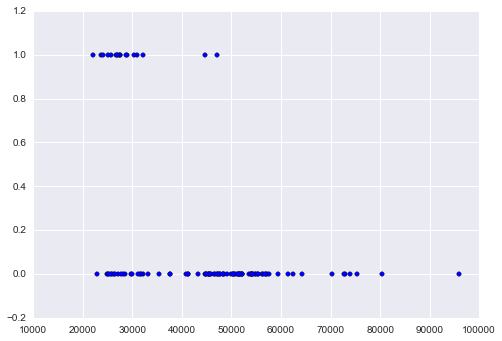

In [21]:
plt.scatter(length_data['Length'], length_data['Y'])

TODO: comment on the plot above.

### Logistic Regression

In addition to simple linear regression, we also carry out a logistic regression. Since the dependent variable is binary, perhaps the logistic regression will give us a better indicator of the relationship between length of statement and the rate change.

In [27]:
import statsmodels.api as sm
from statsmodels.formula.api import logit

length_logistic = logit('Y ~ Length', length_data).fit()
length_logistic.summary()

Optimization terminated successfully.
         Current function value: 0.304335
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                  103
Model:                          Logit   Df Residuals:                      101
Method:                           MLE   Df Model:                            1
Date:                Thu, 10 Dec 2015   Pseudo R-squ.:                  0.3206
Time:                        18:21:03   Log-Likelihood:                -31.346
converged:                       True   LL-Null:                       -46.139
                                        LLR p-value:                 5.354e-08
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      3.9017      1.254      3.111      0.002         1.443     6.360
Length        -0.0002   3.89e-05     -3.878      0.000        -0.000 -7.46e-05
==============================================================================
"""

## 5.3: Regression commentary

TODO: explain the shortcomings of regression in this example.

# Part 6: Conclusions and Evaluation

TODO: Ensemble method that brings it all together